In [1]:
# Import the libraries
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
import glob
import pickle
from sklearn import preprocessing

In [2]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.models import  Model,load_model, model_from_json, Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

In [3]:
SIZE  = 224
batch_size = 32

In [5]:
import numpy as np

In [6]:
train_images, train_labels = [], []
for directory_path in glob.glob("Training/*"):
    tr_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        train_images.append(img)
        train_labels.append(tr_label)

In [7]:
test_images, test_labels = [], []
for directory_path in glob.glob("Testing/*"):
    ts_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        test_images.append(img)
        test_labels.append(ts_label)

In [8]:
# Convert images and labels to numpy arrays
x_train = np.array(train_images)
y_train = np.array(train_labels)
x_test = np.array(test_images)
y_test = np.array(test_labels)

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8406, 224, 224, 3), (8406,), (2104, 224, 224, 3), (2104,))

In [10]:
# Encode labels from text to integers
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode y values for the neural network
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train_encoded, num_classes=5)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=5)

In [11]:
x_train.shape, y_train_one_hot.shape, x_test.shape, y_test_one_hot.shape

((8406, 224, 224, 3), (8406, 5), (2104, 224, 224, 3), (2104, 5))

In [12]:
import keras

In [13]:
base_model = ResNet50V2(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [14]:
from tensorflow.keras import layers 
import tensorflow as tf
for layer in base_model.layers:
    layer.trainable = False

In [15]:
base_model.trainable=False
classifier=Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(5,activation='softmax'))

In [16]:
# Compiling the model
classifier.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [18]:
history = classifier.fit(x_train, y_train_one_hot, epochs=50, batch_size=32)

Epoch 1/50
263/263 [==============================] - 277s 1s/step - loss: 145.3745 - accuracy: 0.8846
Epoch 2/50
263/263 [==============================] - 293s 1s/step - loss: 25.5082 - accuracy: 0.9550
Epoch 3/50
263/263 [==============================] - 295s 1s/step - loss: 19.5391 - accuracy: 0.9690
Epoch 4/50
263/263 [==============================] - 279s 1s/step - loss: 13.5765 - accuracy: 0.9778
Epoch 5/50
263/263 [==============================] - 278s 1s/step - loss: 13.2610 - accuracy: 0.9788
Epoch 6/50
263/263 [==============================] - 276s 1s/step - loss: 3.6294 - accuracy: 0.9912
Epoch 7/50
263/263 [==============================] - 278s 1s/step - loss: 23.8874 - accuracy: 0.9755
Epoch 8/50
263/263 [==============================] - 277s 1s/step - loss: 8.3809 - accuracy: 0.9861
Epoch 9/50
263/263 [==============================] - 276s 1s/step - loss: 8.8415 - accuracy: 0.9883
Epoch 10/50
263/263 [==============================] - 278s 1s/step - loss: 14.3474 

In [19]:
prediction_NN = classifier.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = label_encoder.inverse_transform(prediction_NN)

66/66 [==============================] - 71s 1s/step


In [20]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)

[[1189    0    0    0    0]
 [   2  153    0    1    0]
 [   0    0  156    0    0]
 [   1    2    0  124    0]
 [   0    0    0    0  476]]


In [21]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_NN))

Accuracy =  0.997148288973384


In [22]:
# Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# print(class_labels)
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
print(confusion_matrix(test_labels, prediction_NN))
print(classification_report(test_labels, prediction_NN, target_names=target_names,digits=3))

[[1189    0    0    0    0]
 [   2  153    0    1    0]
 [   0    0  156    0    0]
 [   1    2    0  124    0]
 [   0    0    0    0  476]]
              precision    recall  f1-score   support

     Class 0      0.997     1.000     0.999      1189
     Class 1      0.987     0.981     0.984       156
     Class 2      1.000     1.000     1.000       156
     Class 3      0.992     0.976     0.984       127
     Class 4      1.000     1.000     1.000       476

    accuracy                          0.997      2104
   macro avg      0.995     0.991     0.993      2104
weighted avg      0.997     0.997     0.997      2104



In [24]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

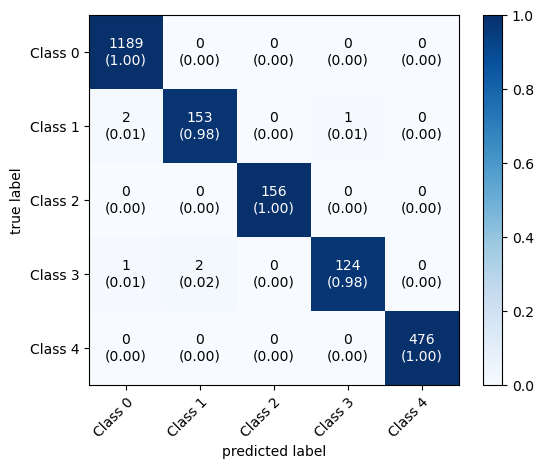

In [25]:
class_dict = {0: 'Class 0',
              1: 'Class 1',
              2: 'Class 2',
              3: 'Class 3',
              4: 'Class 4'}

multiclass = np.array([[1189,    0,    0,    0,    0],
                       [2,  153,    0,    1,    0],
                       [0,    0,  156,    0,    0],
                       [1,    2,    0,  124,    0],
                       [0,    0,    0,    0,  476]])

fig, ax = plot_confusion_matrix(
    conf_mat=multiclass,
    class_names=class_dict.values(),show_normed=True,colorbar=True)